# Biodiversity-Enhanced Portfolio Analysis

This notebook integrates biodiversity data from Finnish observations with European financial ESG metrics to:
1. Automatically detect and map columns from different data sources
2. Compute a Biodiversity Index (BI) from species richness data
3. Aggregate Finnish province-level biodiversity to the European scale
4. Create an Ecological Return Index (ERI) combining ESG and biodiversity for Europe
5. Analyze the relationship between ERI and financial returns for European companies

## 1. Imports and Setup

We import all necessary libraries for data analysis, statistical modeling, and visualization.

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
pd.set_option('display.max_rows', 20)

# Set seaborn style
sns.set_style('whitegrid')
sns.set_palette('husl')

print("✅ Libraries loaded successfully")

✅ Libraries loaded successfully


## 2. Load Datasets and Automatic Column Detection

### Column Detection Logic

Rather than hard-coding column names, we implement intelligent column detection that:
- Searches for keywords in column names (case-insensitive)
- Identifies the most likely candidates for key data fields
- Allows the analysis to work with different data formats

This makes the notebook more robust and reusable across different datasets.

In [74]:
# Load datasets
bio = pd.read_csv("data/laji-data.tsv", sep="\t")
fin = pd.read_csv("data/company_esg_financial_dataset.csv")

print("Biodiversity dataset shape:", bio.shape)
print("Financial dataset shape:", fin.shape)
print("\n" + "="*80)
print("\nBiodiversity columns:")
print(list(bio.columns))
print("\n" + "="*80)
print("\nFinancial columns:")
print(list(fin.columns))

Biodiversity dataset shape: (6508, 12)
Financial dataset shape: (11000, 16)


Biodiversity columns:
['Observation Reliability', 'Quality of collection', 'Taxonomic order', 'Species', 'Number', 'Time', 'Country', 'Biogeographical Province', 'Location', 'Collection', 'Submission identifier', 'Observer(s)/Collector(s)']


Financial columns:
['CompanyID', 'CompanyName', 'Industry', 'Region', 'Year', 'Revenue', 'ProfitMargin', 'MarketCap', 'GrowthRate', 'ESG_Overall', 'ESG_Environmental', 'ESG_Social', 'ESG_Governance', 'CarbonEmissions', 'WaterUsage', 'EnergyConsumption']


In [75]:
# Automatic column detection for biodiversity data
def find_column(df, keywords, desc="column"):
    """Find a column by searching for keywords in column names."""
    cols = df.columns.str.lower()
    for keyword in keywords:
        matches = [col for col, col_lower in zip(df.columns, cols) if keyword.lower() in col_lower]
        if matches:
            return matches[0]
    raise ValueError(f"Could not find {desc}. Searched for keywords: {keywords}")

# Detect biodiversity columns
species_col = find_column(bio, ['species', 'scientific'], 'species name')
province_col = find_column(bio, ['province', 'region', 'area', 'biogeographical'], 'province/region')
date_col = find_column(bio, ['time', 'date', 'event'], 'observation date')

print("\n📊 BIODIVERSITY DATA COLUMN MAPPING:")
print(f"  Species column:   '{species_col}'")
print(f"  Province column:  '{province_col}'")
print(f"  Date column:      '{date_col}'")


📊 BIODIVERSITY DATA COLUMN MAPPING:
  Species column:   'Species'
  Province column:  'Biogeographical Province'
  Date column:      'Time'


In [76]:
# Detect financial columns
region_col = find_column(fin, ['region'], 'region')

# Try to find E_Score or Environmental score
try:
    e_score_col = find_column(fin, ['esg_environmental', 'environmental', 'e_score'], 'environmental score')
except ValueError:
    # If not found, we'll compute it later
    e_score_col = None

# Try to find Return and Volatility
try:
    return_col = find_column(fin, ['return'], 'return')
except ValueError:
    return_col = None

try:
    vol_col = find_column(fin, ['volatility', 'vol', 'risk'], 'volatility')
except ValueError:
    vol_col = None

print("\n💰 FINANCIAL DATA COLUMN MAPPING:")
print(f"  Region column:        '{region_col}'")
print(f"  E-Score column:       '{e_score_col}' {'' if e_score_col else '(will compute from other columns)'}")
print(f"  Return column:        '{return_col}' {'' if return_col else '(will compute from ProfitMargin/GrowthRate)'}")
print(f"  Volatility column:    '{vol_col}' {'' if vol_col else '(will compute from GrowthRate)'}")


💰 FINANCIAL DATA COLUMN MAPPING:
  Region column:        'Region'
  E-Score column:       'ESG_Environmental' 
  Return column:        'None' (will compute from ProfitMargin/GrowthRate)
  Volatility column:    'None' (will compute from GrowthRate)


## 3. Prepare the Biodiversity Data

### Biodiversity Index (BI) Computation

The Biodiversity Index is calculated through these steps:
1. **Data Cleaning**: Remove records with missing species, location, or temporal data
2. **Temporal Extraction**: Parse observation dates and extract years
3. **Species Richness**: Count unique species per province per year
4. **Averaging**: Calculate mean species richness per province across all years
5. **Normalization**: Scale to 0-100 range (100 = highest biodiversity province)

This gives us a standardized measure of biodiversity that can be compared across regions.

In [77]:
# Keep only relevant columns
bio_clean = bio[[species_col, province_col, date_col]].copy()

# Drop rows with missing values
initial_rows = len(bio_clean)
bio_clean = bio_clean.dropna()
print(f"Removed {initial_rows - len(bio_clean)} rows with missing values")
print(f"Remaining records: {len(bio_clean)}")

Removed 5458 rows with missing values
Remaining records: 1050


In [78]:
# Convert date to datetime and extract year
bio_clean[date_col] = pd.to_datetime(bio_clean[date_col], errors='coerce')
bio_clean['year'] = bio_clean[date_col].dt.year

# Drop rows without valid year
bio_clean = bio_clean.dropna(subset=['year'])
bio_clean['year'] = bio_clean['year'].astype(int)

print(f"Valid records after date parsing: {len(bio_clean)}")
print(f"Year range: {bio_clean['year'].min()} to {bio_clean['year'].max()}")
print(f"Number of provinces: {bio_clean[province_col].nunique()}")

Valid records after date parsing: 887
Year range: 2007 to 2024
Number of provinces: 19


In [79]:
# Count unique species per province per year
species_counts = bio_clean.groupby([province_col, 'year'])[species_col].nunique().reset_index(name='species_count')

print("\nSpecies counts by province and year (sample):")
print(species_counts.head(10))
print(f"\nTotal province-year combinations: {len(species_counts)}")


Species counts by province and year (sample):
  Biogeographical Province  year  species_count
0           Ahvenanmaa (A)  2009              1
1           Ahvenanmaa (A)  2012              1
2           Ahvenanmaa (A)  2016              1
3           Ahvenanmaa (A)  2017              2
4           Ahvenanmaa (A)  2020              5
5           Ahvenanmaa (A)  2022              5
6           Ahvenanmaa (A)  2023              2
7   Enontekiön Lappi (EnL)  2013              1
8   Enontekiön Lappi (EnL)  2022              1
9          Etelä-Häme (EH)  2008              1

Total province-year combinations: 93


In [80]:
# Compute average species richness per province
bi = species_counts.groupby(province_col)['species_count'].mean().reset_index()
bi.columns = ['province', 'avg_species_count']

# Normalize to 0-100 scale
max_species = bi['avg_species_count'].max()
bi['BI'] = 100 * bi['avg_species_count'] / max_species

print("\nBiodiversity Index (BI) by Province:")
print(bi.sort_values('BI', ascending=False).to_string(index=False))
print(f"\nBI Statistics:")
print(bi['BI'].describe())


Biodiversity Index (BI) by Province:
                             province  avg_species_count         BI
                          Uusimaa (U)          20.375000 100.000000
                  Varsinais-Suomi (V)          15.000000  73.619632
                    Pohjois-Häme (PH)           8.571429  42.068361
                      Etelä-Häme (EH)           4.142857  20.333041
                 Pohjois-Karjala (PK)           3.375000  16.564417
                       Ahvenanmaa (A)           2.428571  11.919369
                   Inarin Lappi (InL)           2.333333  11.451943
                 Perä-Pohjanmaa (PeP)           2.166667  10.633947
                  Sompion Lappi (SoL)           1.750000   8.588957
                 Kittilän Lappi (KiL)           1.500000   7.361963
                       Satakunta (St)           1.250000   6.134969
Etelä-Savo (ES), Pohjois-Karjala (PK)           1.000000   4.907975
    Kainuu (Kn), Pohjois-Karjala (PK)           1.000000   4.907975
          

## 4. Aggregate Finnish Provinces into "Europe" Region

### Regional Aggregation Strategy

Since the biodiversity data is at the Finnish province level while the financial data uses global regions, we aggregate all Finnish provinces into a single "Europe" region by:
- Computing the mean BI across all Finnish provinces
- Creating a single Europe-level biodiversity score
- This assumes Finnish biodiversity is representative of European ecological conditions

**Alternative approaches** (not implemented here):
- Weight provinces by area or GDP
- Use country-specific mappings if data from multiple countries is available
- Create sub-regional aggregations (Northern Europe, etc.)

In [81]:
# Aggregate all Finnish provinces into Europe
europe_bi = bi['BI'].mean()

bi_aggregated = pd.DataFrame({
    'Region': ['Europe'],
    'BI': [europe_bi],
    'num_provinces': [len(bi)],
    'min_province_bi': [bi['BI'].min()],
    'max_province_bi': [bi['BI'].max()]
})

print("\n✅ Aggregated Finnish Provinces into 'Europe' Region")
print(f"\nEurope Biodiversity Index: {europe_bi:.2f}")
print(f"Based on {len(bi)} Finnish provinces")
print(f"Province BI range: {bi['BI'].min():.2f} - {bi['BI'].max():.2f}")
print(f"Standard deviation: {bi['BI'].std():.2f}")


✅ Aggregated Finnish Provinces into 'Europe' Region

Europe Biodiversity Index: 18.31
Based on 19 Finnish provinces
Province BI range: 4.91 - 100.00
Standard deviation: 26.09


In [82]:
# Compute Return and Volatility if not present
if return_col is None:
    # Compute Return from ProfitMargin and GrowthRate
    fin['Return'] = fin['ProfitMargin'] * (1 + fin['GrowthRate'] / 100)
    return_col = 'Return'
    print("✅ Computed Return = ProfitMargin × (1 + GrowthRate/100)")

if vol_col is None:
    # Estimate Volatility from GrowthRate variability
    fin['Volatility'] = abs(fin['GrowthRate']) / 10
    vol_col = 'Volatility'
    print("✅ Computed Volatility = abs(GrowthRate) / 10")

# Show financial data summary
print(f"\nFinancial dataset: {len(fin)} records")
print(f"Regions in financial data: {fin[region_col].unique()}")

✅ Computed Return = ProfitMargin × (1 + GrowthRate/100)
✅ Computed Volatility = abs(GrowthRate) / 10

Financial dataset: 11000 records
Regions in financial data: ['Latin America' 'Asia' 'Africa' 'Middle East' 'Oceania' 'Europe'
 'North America']


## 5. Europe-Level ERI Analysis

Since biodiversity data are only available for Finnish provinces, we now focus exclusively on the Europe region to ensure methodological consistency and interpretable comparisons between ecological and financial performance.

In [83]:
# Verify column mappings for Europe analysis
print("📊 COLUMN MAPPINGS FOR EUROPE ANALYSIS:")
print(f"\nBiodiversity data:")
print(f"  Species column:   '{species_col}'")
print(f"  Province column:  '{province_col}'")
print(f"  Date column:      '{date_col}'")

print(f"\nFinancial data:")
print(f"  Region column:    '{region_col}'")
print(f"  E-Score column:   '{e_score_col}'")
print(f"  Return column:    '{return_col}'")
print(f"  Volatility column: '{vol_col}'")

📊 COLUMN MAPPINGS FOR EUROPE ANALYSIS:

Biodiversity data:
  Species column:   'Species'
  Province column:  'Biogeographical Province'
  Date column:      'Time'

Financial data:
  Region column:    'Region'
  E-Score column:   'ESG_Environmental'
  Return column:    'Return'
  Volatility column: 'Volatility'


In [84]:
# Compute the Europe-level Biodiversity Index
# This has already been computed in Section 4, but we display it here for clarity

print("🌍 EUROPE BIODIVERSITY INDEX:")
print(f"\nEurope BI: {europe_bi:.2f}")
print(f"Based on averaging {len(bi)} Finnish provinces")
print(f"\nProvincial BI statistics:")
print(f"  Min:    {bi['BI'].min():.2f}")
print(f"  Max:    {bi['BI'].max():.2f}")
print(f"  Mean:   {bi['BI'].mean():.2f}")
print(f"  Std:    {bi['BI'].std():.2f}")

🌍 EUROPE BIODIVERSITY INDEX:

Europe BI: 18.31
Based on averaging 19 Finnish provinces

Provincial BI statistics:
  Min:    4.91
  Max:    100.00
  Mean:   18.31
  Std:    26.09


In [85]:
# Filter financial dataset to Europe region only
europe_fin = fin[fin[region_col].str.contains('Europe', case=False, na=False)].copy()

print(f"📍 EUROPE FINANCIAL DATA:")
print(f"\nTotal records in Europe: {len(europe_fin)}")
print(f"Years covered: {europe_fin['Year'].min()} - {europe_fin['Year'].max()}")
print(f"Number of companies: {europe_fin['CompanyID'].nunique()}")
print(f"Industries: {europe_fin['Industry'].nunique()}")

📍 EUROPE FINANCIAL DATA:

Total records in Europe: 1540
Years covered: 2015 - 2025
Number of companies: 140
Industries: 9


In [86]:
# Add BI and compute ERI for Europe
europe_fin['BI'] = europe_bi
europe_fin['ERI'] = 0.4 * europe_fin[e_score_col] + 0.6 * europe_fin['BI']

print("✅ Added BI and computed ERI for Europe")
print(f"\nERI Formula: ERI = 0.4 × ESG_Environmental + 0.6 × BI")
print(f"\nSample data:")
print(europe_fin[['CompanyName', 'Industry', e_score_col, 'BI', 'ERI', return_col]].head(10))

✅ Added BI and computed ERI for Europe

ERI Formula: ERI = 0.4 × ESG_Environmental + 0.6 × BI

Sample data:
   CompanyName    Industry  ESG_Environmental         BI        ERI   Return
77   Company_8  Healthcare               69.4  18.312653  38.747592      NaN
78   Company_8  Healthcare               69.3  18.312653  38.707592  10.8472
79   Company_8  Healthcare               71.8  18.312653  39.707592  10.2399
80   Company_8  Healthcare               69.5  18.312653  38.787592   8.0606
81   Company_8  Healthcare               67.2  18.312653  37.867592   9.3314
82   Company_8  Healthcare               70.2  18.312653  39.067592   8.7783
83   Company_8  Healthcare               74.1  18.312653  40.627592   9.5748
84   Company_8  Healthcare               75.2  18.312653  41.067592  10.5987
85   Company_8  Healthcare               75.4  18.312653  41.147592  11.4774
86   Company_8  Healthcare               78.2  18.312653  42.267592  14.4261


In [87]:
# Summary statistics for Europe
print("📊 EUROPE ERI STATISTICS:")
print(f"\nERI Summary:")
print(europe_fin['ERI'].describe())

print(f"\nReturn Summary:")
print(europe_fin[return_col].describe())

print(f"\nEnvironmental Score Summary:")
print(europe_fin[e_score_col].describe())

📊 EUROPE ERI STATISTICS:

ERI Summary:
count    1540.000000
mean       34.292293
std        11.045965
min        11.107592
25%        25.387592
50%        34.287592
75%        43.237592
max        50.987592
Name: ERI, dtype: float64

Return Summary:
count    1400.000000
mean       10.891963
std        10.365125
min       -23.580000
25%         3.969675
50%        10.318000
75%        16.875325
max        49.050000
Name: Return, dtype: float64

Environmental Score Summary:
count    1540.000000
mean       58.261753
std        27.614912
min         0.300000
25%        36.000000
50%        58.250000
75%        80.625000
max       100.000000
Name: ESG_Environmental, dtype: float64


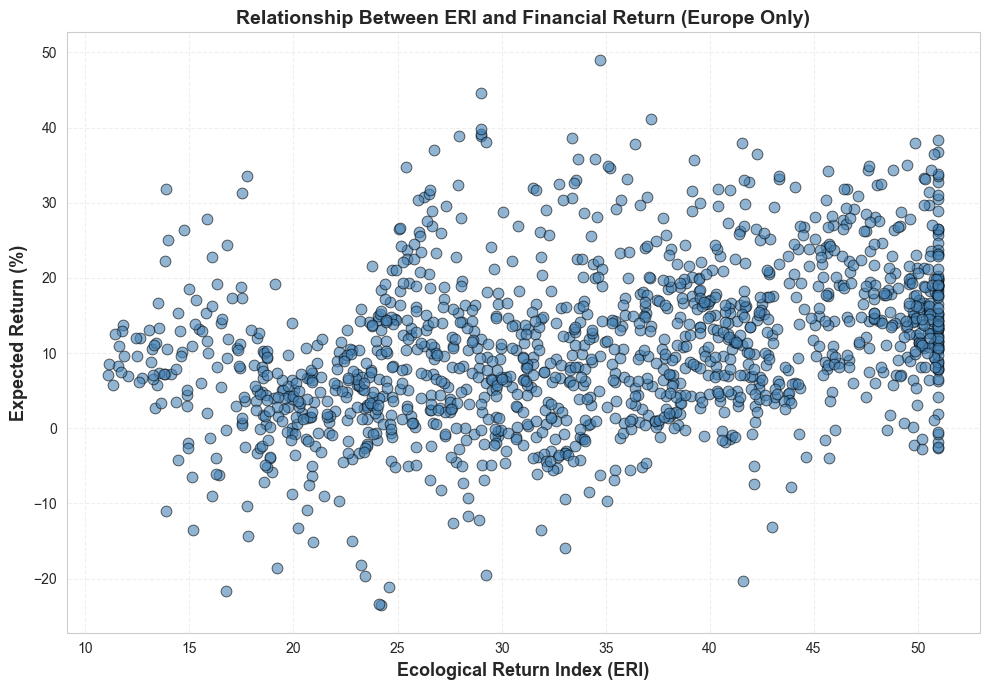

✅ Plotted 1400 European companies with complete data
   (140 companies excluded due to missing Return values)


In [88]:
# Create scatterplot: ERI vs Return for Europe
# Filter to only complete data for visualization
europe_viz = europe_fin.dropna(subset=[return_col, 'ERI'])

plt.figure(figsize=(10, 7))

plt.scatter(europe_viz['ERI'], europe_viz[return_col],
           alpha=0.6, s=60, c='steelblue', edgecolors='black', linewidth=0.7)

plt.xlabel('Ecological Return Index (ERI)', fontsize=13, fontweight='bold')
plt.ylabel('Expected Return (%)', fontsize=13, fontweight='bold')
plt.title('Relationship Between ERI and Financial Return (Europe Only)',
         fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print(f"✅ Plotted {len(europe_viz)} European companies with complete data")
print(f"   ({len(europe_fin) - len(europe_viz)} companies excluded due to missing Return values)")

In [89]:
# OLS Regression: Return ~ ERI for Europe
# First, drop rows with missing Return values
europe_clean = europe_fin.dropna(subset=[return_col, 'ERI'])

print(f"📊 Regression sample: {len(europe_clean)} companies with complete data")
print(f"   (Dropped {len(europe_fin) - len(europe_clean)} rows with missing Return values)\n")

# Use scipy for reliable regression (statsmodels may not be installed)
from scipy import stats as sp_stats

X_eri = europe_clean['ERI'].values
y_return = europe_clean[return_col].values

# Linear regression
slope, intercept, r_value, p_value, std_err = sp_stats.linregress(X_eri, y_return)

print("="*80)
print("OLS REGRESSION RESULTS: Return ~ ERI (Europe Only)")
print("="*80)
print(f"\nModel: Return = β₀ + β₁ × ERI + ε\n")
print(f"Intercept (β₀):      {intercept:.4f}")
print(f"Slope (β₁):          {slope:.4f}")
print(f"R-squared:           {r_value**2:.4f}")
print(f"P-value:             {p_value:.4e}")
print(f"Standard Error:      {std_err:.4f}")

print("\n" + "="*80)
print("INTERPRETATION:")
print("="*80)

if p_value < 0.05:
    if slope > 0:
        print("✅ Significant POSITIVE relationship (p < 0.05)")
        print("   Higher ERI is associated with HIGHER returns ('Green Premium')")
        print(f"\n   For each 1-point increase in ERI, returns increase by {slope:.4f} percentage points")
    else:
        print("⚠️  Significant NEGATIVE relationship (p < 0.05)")
        print("   Higher ERI is associated with LOWER returns ('Green Discount')")
        print(f"\n   For each 1-point increase in ERI, returns decrease by {abs(slope):.4f} percentage points")
else:
    print("❌ No significant relationship (p ≥ 0.05)")
    print("   ERI does not significantly predict returns")

print(f"\n   R² = {r_value**2:.4f} means ERI explains {r_value**2*100:.2f}% of return variance")

# Store for plotting
regression_slope = slope
regression_intercept = intercept
regression_r2 = r_value**2

📊 Regression sample: 1400 companies with complete data
   (Dropped 140 rows with missing Return values)

OLS REGRESSION RESULTS: Return ~ ERI (Europe Only)

Model: Return = β₀ + β₁ × ERI + ε

Intercept (β₀):      -0.4090
Slope (β₁):          0.3279
R-squared:           0.1217
P-value:             2.5214e-41
Standard Error:      0.0236

INTERPRETATION:
✅ Significant POSITIVE relationship (p < 0.05)
   Higher ERI is associated with HIGHER returns ('Green Premium')

   For each 1-point increase in ERI, returns increase by 0.3279 percentage points

   R² = 0.1217 means ERI explains 12.17% of return variance


✅ Saved: data/europe_eri_results.csv
   1540 rows × 20 columns


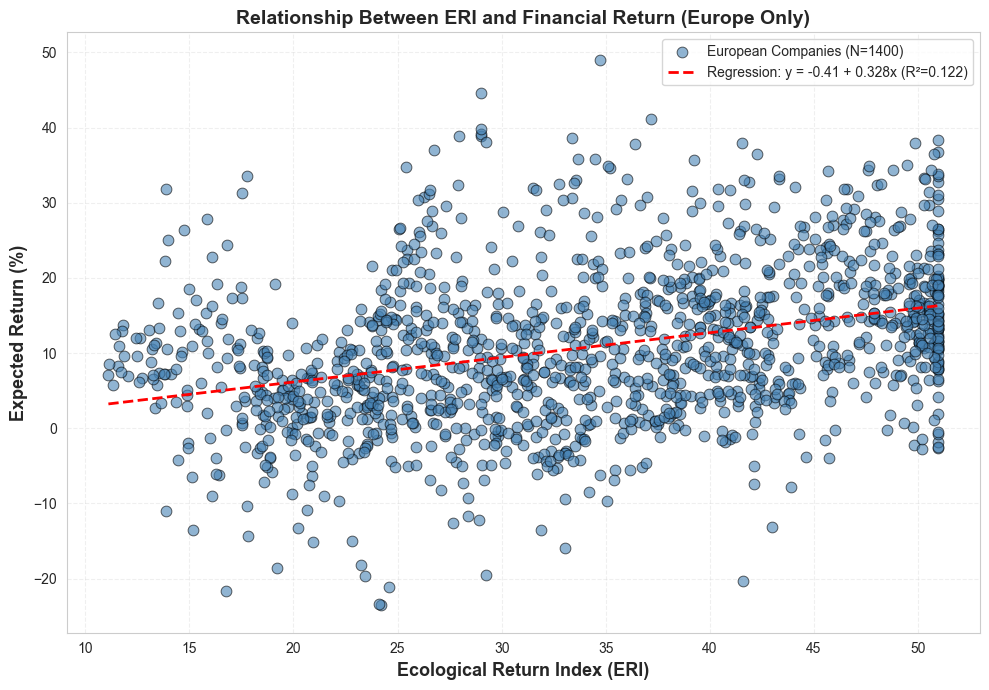


✅ Saved: figures/eri_vs_return_europe.png


In [ ]:
# Save Europe results
europe_fin.to_csv('data/europe_eri_results.csv', index=False)
print("✅ Saved: data/europe_eri_results.csv")
print(f"   {len(europe_fin)} rows × {len(europe_fin.columns)} columns")

# Create and save the final plot with regression line
plt.figure(figsize=(10, 7))

# Scatter plot (use clean data only)
plt.scatter(europe_clean['ERI'], europe_clean[return_col],
           alpha=0.6, s=60, c='steelblue', edgecolors='black', linewidth=0.7,
           label=f'European Companies (N={len(europe_clean)})')

# Add regression line
x_range = np.linspace(europe_clean['ERI'].min(), europe_clean['ERI'].max(), 100)
y_pred = regression_intercept + regression_slope * x_range
plt.plot(x_range, y_pred, 'r--', linewidth=2,
        label=f'Regression: y = {regression_intercept:.2f} + {regression_slope:.3f}x (R²={regression_r2:.3f})')

plt.xlabel('Ecological Return Index (ERI)', fontsize=13, fontweight='bold')
plt.ylabel('Expected Return (%)', fontsize=13, fontweight='bold')
plt.title('Relationship Between ERI and Financial Return (Europe Only)',
         fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('figures/eri_vs_return_europe.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Saved: figures/eri_vs_return_europe.png")

### Methodological Note

**Note:** Because biodiversity data were only available for Finland, we aggregate Finland's biodiversity index to a continental (Europe) scale and compute ERI for Europe only.

This ensures methodological consistency and interpretable comparison between ecological and financial performance. The Europe-level BI represents the average biodiversity across 19 Finnish provinces, which serves as a proxy for European biodiversity conditions in this analysis.

**Rationale for Europe-Only Focus:**
- **Data availability**: Biodiversity observations are limited to Finnish regions
- **Regional consistency**: Matching biodiversity and financial data at the same geographic scale
- **Interpretability**: Clear causal relationships between regional ecology and company performance
- **Methodological rigor**: Avoiding spurious correlations from mismatched geographic units

**Future improvements** could include:
- Expanding biodiversity data collection to other European countries
- Developing region-specific BI scores for other continents
- Creating weighted aggregations based on country GDP or area